In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np

def MACD(ohlc, period_fast = 12, period_slow = 26, signal = 9, column = "Close", adjust = True):
    EMA_fast = pd.Series(
        ohlc[column].ewm(ignore_na=False, span=period_fast, adjust=adjust).mean(),
        name="EMA_fast",
    )
    EMA_slow = pd.Series(
        ohlc[column].ewm(ignore_na=False, span=period_slow, adjust=adjust).mean(),
        name="EMA_slow",
    )
    MACD = pd.Series(EMA_fast - EMA_slow, name="MACD")
    MACD_signal = pd.Series(
        MACD.ewm(ignore_na=False, span=signal, adjust=adjust).mean(), name="SIGNAL"
    )

    return pd.concat([MACD, MACD_signal], axis=1)

In [66]:
# loading in data
hourly = pd.read_csv('hourlyUPRO14-24.csv')
hourly = hourly.iloc[::-1]
hourly['Date'] = pd.to_datetime(hourly['Date'])
hourly.set_index('Date', inplace=True)
hourly = hourly.rename(columns={'Last Price': 'Close'})

daily = pd.read_csv('dailyUPRO14-24.csv')
daily['Date'] = pd.to_datetime(daily['Date'])
daily.set_index('Date', inplace=True)
daily = daily.drop(columns=['Close'])
daily = daily.rename(columns={'Adj Close': 'Close'})

# calculating MACD
macd = MACD(daily)
daily['MACD'] = macd['MACD']
daily['SIGNAL'] = macd['SIGNAL']
daily['HIST_MACD'] = daily['MACD'] - daily['SIGNAL']
daily.dropna(inplace=True)

hourly_macd = MACD(hourly)
hourly['MACD_hourly'] = hourly_macd['MACD']
hourly['SIGNAL_hourly'] = hourly_macd['SIGNAL']
hourly['HIST_MACD_hourly'] = hourly['MACD_hourly'] - hourly['SIGNAL_hourly']
hourly.dropna(inplace=True)

# calculating the last hourly MACD value for each day
eod_hourly = hourly.groupby(hourly.index.date).last()

In [67]:
# check what date is in daily but not eod_hourly (there was 1 day missing from yfinance that was in bloomberg idk)
daily_dates = daily.index.date
eod_hourly_dates = eod_hourly.index
for date in daily_dates:
    if date not in eod_hourly_dates:
        print(date)
# drop 2019-07-23 from daily
daily.drop(index='2019-07-23', inplace=True)
len(daily) == len(eod_hourly)

2019-07-23


True

In [68]:
# buying and selling EOD

buy_conditions = lambda i: (daily.iloc[i]['MACD'] > (daily.iloc[i]['SIGNAL']-0.5) and eod_hourly.iloc[i]['MACD_hourly'] > (eod_hourly.iloc[i]['SIGNAL_hourly']))
sell_conditions = lambda i: daily.iloc[i]['MACD'] < (daily.iloc[i]['SIGNAL']-0.1)

cash = 1000
shares = 0
buy_price = 0 
portfolio_values = []
buy_dates = []
sell_dates = []
buy_portfolio_values = []
sell_portfolio_values = []
stop_loss_price = 0

for i in range(1, len(daily)):
    # Buy at the close price if current MACD is above the signal line
    if buy_conditions(i) and cash > daily.iloc[i]['Close']:
        shares_bought = cash // daily.iloc[i]['Close']
        cash -= shares_bought * daily.iloc[i]['Close']
        shares += shares_bought
        buy_price = daily.iloc[i]['Close']
        buy_dates.append(daily.index[i])
        buy_portfolio_values.append(cash + shares * daily.iloc[i]['Close'])
        stop_loss_price = daily.iloc[i]['Close']*0.95
        
    
    elif shares > 0 and daily.iloc[i]['Low'] < stop_loss_price:
        cash += shares * stop_loss_price
        shares = 0
        sell_dates.append(daily.index[i])
        sell_portfolio_values.append(cash)

    elif shares > 0 and (sell_conditions(i)):
        cash += shares * daily.iloc[i]['Close']
        shares = 0
        sell_dates.append(daily.index[i])
        sell_portfolio_values.append(cash)
    
    portfolio_value = cash + shares * daily.iloc[i]['Close']
    portfolio_values.append(portfolio_value)


# Calculate the final portfolio value
portfolio_value = cash + shares * daily.iloc[-1]['Close']

# drop first row in daily
daily = daily.iloc[1:]
eod_hourly = eod_hourly.iloc[1:]

print(f'Final portfolio value: {portfolio_value}')


running_max = np.maximum.accumulate(portfolio_values)
drawdown = (running_max - portfolio_values) / running_max
max_drawdown = np.max(drawdown)

print(f'Maximum Drawdown: {-100*max_drawdown}')

Final portfolio value: 19473.702839549987
Maximum Drawdown: -34.57029598009504


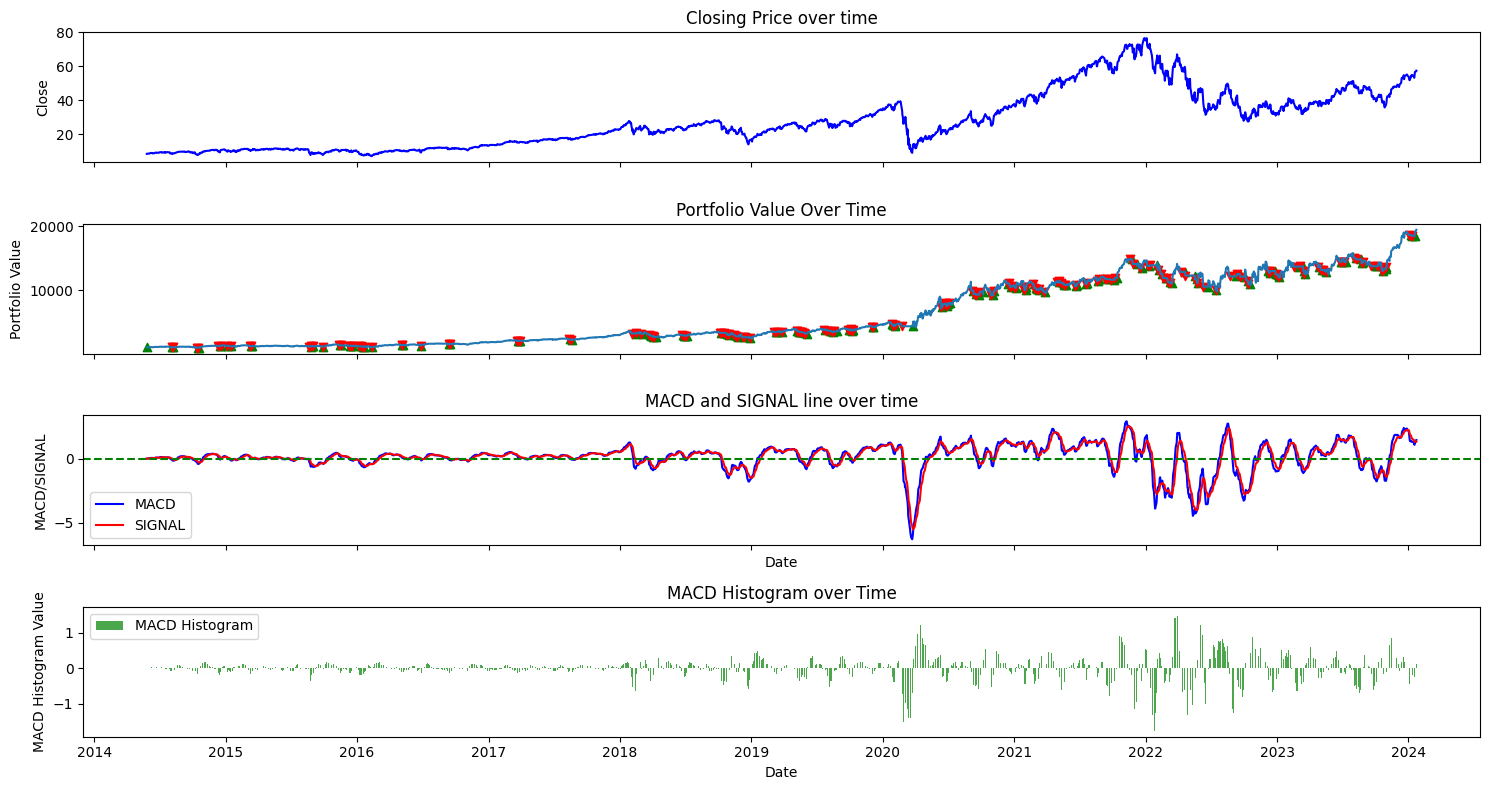

In [69]:
# Create subplots
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, sharex=True, figsize=(15,8))

# Plot Closing Price
ax1.plot(daily.index, daily['Close'], label='Close', color='blue')
ax1.set_title('Closing Price over time')
ax1.set_ylabel('Close')

ax2.plot(daily.index, portfolio_values)
ax2.scatter(buy_dates, buy_portfolio_values, color='g', marker='^')  # buy markers
ax2.scatter(sell_dates, sell_portfolio_values, color='r', marker='v')  # sell markers
ax2.set_title('Portfolio Value Over Time')
ax2.set_ylabel('Portfolio Value')

# Plot MACD
ax3.plot(daily.index, daily['MACD'], label='MACD', color='blue')
ax3.plot(daily.index, daily['SIGNAL'], label='SIGNAL', color='red')
ax3.set_title('MACD and SIGNAL line over time')
ax3.set_xlabel('Date')
ax3.set_ylabel('MACD/SIGNAL')
ax3.legend()
ax3.axhline(0, color='green', linestyle='--')

ax4.bar(daily.index, daily['HIST_MACD'], label='MACD Histogram', color='green', alpha=0.7)
ax4.legend(loc='upper left')
ax4.set_title('MACD Histogram over Time')
ax4.set_xlabel('Date')
ax4.set_ylabel('MACD Histogram Value')

# Display the figure
plt.tight_layout()
plt.show()

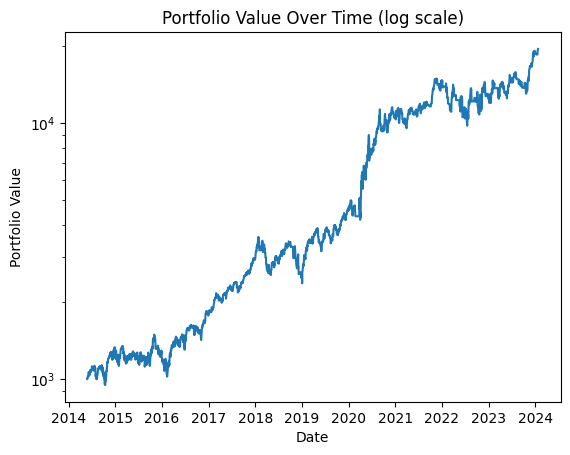

In [70]:
plt.plot(daily.index, portfolio_values)
plt.yscale('log')
plt.title('Portfolio Value Over Time (log scale)')
plt.ylabel('Portfolio Value')
plt.xlabel('Date')
plt.show()


In [72]:
print(f"Number of trades: {len(buy_dates) + len(sell_dates)}")

Number of trades: 361
